# Detector Tomography & Quantum State Reconstruction

In [1]:
import numpy as np
import numpy.typing as npt
from scipy.optimize import curve_fit
from functools import partial
from tqdm.auto import tqdm
from tqdm.contrib.concurrent import process_map
import os
import pickle
import utils, RQS

import matplotlib.pyplot as plt
from matplotlib import ticker

## 1. Detector Tomography

- First run ```python -m scaling``` in the command line to generate probe states and perform detector tomography.
- The following are visualizations

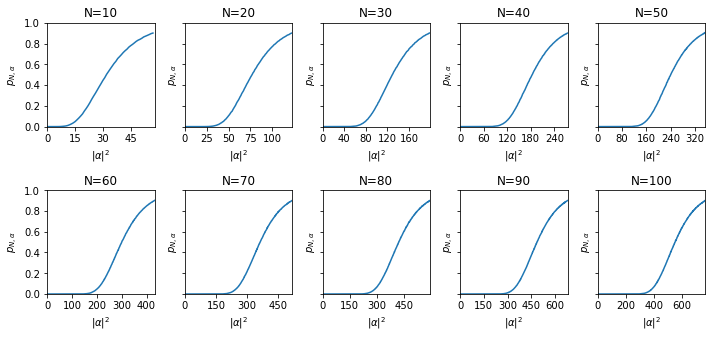

In [2]:
fig, axs = plt.subplots(2, 5, sharey=True, tight_layout=True, figsize=(10, 4.8))
N = np.arange(10, 101, 10)
for i in range(2):
    for j in range(5):
        P = np.load(f'./Data/detector_{N[5*i+j]}/P_coherent.npy')
        axs[i, j].plot(P[:, -1])
        axs[i, j].set_xlim(0, P.shape[0])
        axs[i, j].set_ylim(0, 1)
        axs[i, j].set_xlabel(r'$|\alpha|^2$')
        axs[i, j].set_ylabel(r'$p_{N,\alpha}$')
        axs[i, j].set_title(f'N={N[5*i+j]}')
        axs[i, j].xaxis.set_major_locator(ticker.MaxNLocator(5))
        axs[i, j].yaxis.set_major_locator(ticker.MultipleLocator(.2))

In [45]:
# Tuning the regularization parameter of detector tomography.
# Refer to Schapeler, T., Höpker, J. P. & Bartley, T. J. Quantum detector tomography of a 2x2 multi-pixel array of superconducting nanowire single photon detectors. Opt. Express, OE 28, 33035–33043 (2020).

N = 70
P = np.load(f'./Data/detector_{N}/P_coherent.npy')
solve_time = []
dark_count = [] # dark count probability retrieved from the reconstructed POVM.
for i, gamma in enumerate(tqdm(np.logspace(-5, -1, num=17, endpoint=True))):
    dt = RQS.dt_CVX(P, gamma, improved=True)
    dt.prob.solve(solver='MOSEK', mosek_params={"MSK_IPAR_INTPNT_SOLVE_FORM":2})
    if dt.prob.status != 'optimal':
        tqdm.write(f'{dt.prob.status=} for {N=}')
    
    solve_time.append(dt.prob.solver_stats.solve_time)
    dark_count.append(dt.Pi.value[0, 1])
    tqdm.write(f'solve time = {solve_time[i]:.2f}s,\t dark count probability = {dark_count[i]:.2%}')
    
    path = f'./Data/detector_{N}/regularization'
    if not os.path.exists(path):
        os.mkdir(path)
    np.save(os.path.join(path, f'Pi{i}.npy'), dt.Pi.value)
np.save(os.path.join(path, f'solve_time.npy'), np.array(solve_time))
np.save(os.path.join(path, f'dark_count_probability.npy'), np.array(dark_count))

  0%|          | 0/17 [00:00<?, ?it/s]

solve time = 10.72s,	 dark count probability = 2.44%
solve time = 10.31s,	 dark count probability = 2.67%
solve time = 11.57s,	 dark count probability = 3.04%
solve time = 10.94s,	 dark count probability = 3.57%
solve time = 10.77s,	 dark count probability = 4.40%
solve time = 11.57s,	 dark count probability = 5.70%
solve time = 11.29s,	 dark count probability = 7.68%
solve time = 10.89s,	 dark count probability = 10.50%
solve time = 10.96s,	 dark count probability = 14.23%
solve time = 10.51s,	 dark count probability = 18.67%
solve time = 11.10s,	 dark count probability = 23.58%
solve time = 10.39s,	 dark count probability = 28.73%
solve time = 11.43s,	 dark count probability = 33.14%
solve time = 12.12s,	 dark count probability = 36.60%
solve time = 11.62s,	 dark count probability = 39.01%
solve time = 11.91s,	 dark count probability = 39.98%
solve time = 10.60s,	 dark count probability = 40.46%


efficiency=86.6%
dark-count probability=4.4%
single-pixel cross-talk probability=1.0%


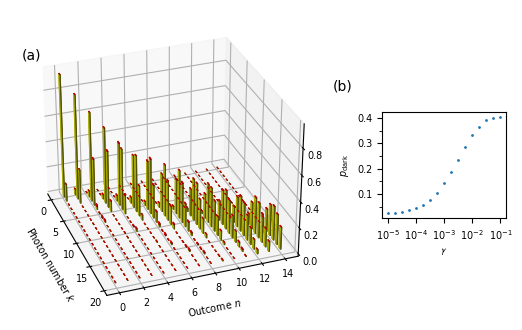

In [7]:
# %matplotlib ipympl
import matplotlib.gridspec as gridspec

Pi_improved = np.load('./Data/detector_70/Pi_improved.npy')
Pi = np.load('./Data/detector_70/Pi.npy')
print(f'efficiency={1-Pi_improved[1, 0]:.1%}', f'dark-count probability={Pi_improved[0, 1]:.1%}', f'single-pixel cross-talk probability={Pi_improved[1, 2]-Pi_improved[1, 1]*Pi_improved[0, 1]:.1%}', sep='\n')

fig = plt.figure()
gs = gridspec.GridSpec(2, 3)
fig.subplots_adjust(wspace=.5, hspace=-.2)
ax1 = fig.add_subplot(gs[:, :-1], projection='3d', azim=-20, elev=30)
ax2 = fig.add_subplot(gs[:, -1], aspect=9)

# Plot bar3d of Pi_improved
n = 15
k = 20
x = np.arange(k)
y = np.arange(n)
x, y = np.meshgrid(x, y)
x, y = x.ravel(), y.ravel()
# Pi_imporved
# ax1.computed_zorder = False
ax1.bar3d(x, y, z=np.zeros_like(x), dx=.5, dy=.1, dz=Pi_improved[:k, :n].T.ravel(), color='y', shade=True)
# The absolute error between Pi_imporved and Pi
ax1.bar3d(x, y, z=Pi_improved[:k, :n].T.ravel(), dx=.5, dy=.1, dz=(np.abs(Pi_improved[:k, :n]-Pi[:k, :n])).T.ravel(), color='r', shade=True)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax1.yaxis.set_major_locator(ticker.MultipleLocator(2))
ax1.set_xlabel('Photon number $k$', fontsize='x-small', labelpad=-5)
ax1.set_ylabel('Outcome $n$', fontsize='x-small', labelpad=-5)
ax1.tick_params(labelsize='x-small', pad=-3)
ax1.text(0, -3, 1.1, '(a)')

# plot dark-count probability vs regularization parameter
gamma = np.logspace(-5, -1, num=17, endpoint=True)
dark_count = np.load('./Data/detector_70/regularization/dark_count_probability.npy')

ax2.scatter(gamma, dark_count, s=1)
ax2.set_xscale('log')
ax2.xaxis.set_major_locator(ticker.FixedLocator([1e-5, 1e-4, 1e-3, 1e-2, 1e-1]))
ax2.yaxis.set_minor_locator(ticker.MultipleLocator(.05))
ax2.set_xlabel('$\mathfrak{\gamma}$', fontsize='x-small')
ax2.set_ylabel('$p_\mathrm{dark}$', fontsize='x-small')
ax2.tick_params(labelsize='x-small')
ax2.text(-.4, 1.2, '(b)', transform=ax2.transAxes)

fig.savefig('./Figures/POVM.pdf', bbox_inches ='tight')

## 2. Reconstruction of Photon Number Distribution

### 2.1 Plot fidelity ~ $\lambda$ curve for coherent states. 

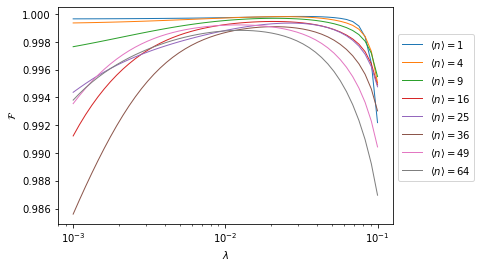

In [33]:
path = './Data/detector_70'
# Pi = np.load(os.path.join(path, 'regularization', 'Pi3.npy'))
EME = RQS.EME(Pi)

nbar = np.arange(1, 9)**2
P = np.load(os.path.join(path, 'P_coherent.npy'))[nbar-1]
lamb = np.logspace(-3, -1)
fidelity_lamb = []
for i, p in enumerate(P):
    fidelity = []
    for g in lamb:
        f = EME.solve(p, g)
        if EME.message['status'] != 'success':
            print(f"{EME.message['status']} for nbar={nbar[i]}, {g=}")
        fidelity.append(utils.fidelity(f, utils.rho(nbar[i], Pi.shape[0]-1, 'coherent')))
    fidelity_lamb.append(fidelity)

fig, ax = plt.subplots()
for i in range(len(nbar)):
    ax.semilogx(lamb, fidelity_lamb[i], label=fr'$\langle n\rangle={nbar[i]}$', lw=1)
    ax.set_xlabel('$\lambda$')
    ax.set_ylabel('$\mathcal{F}$')
legend = fig.legend(loc='center left', bbox_to_anchor=(.9, 0.53))
fig.savefig('./Figures/fidelity_lamb.pdf', bbox_inches='tight', bbox_extra_artists=[legend])

### 2.2 Simulate the measured statistics of coherent and thermal states

In [5]:
def generate_P_reconstr(detector: utils.Monte_Carlo, nbar: npt.NDArray[float], path: str, state: str, P_file: str) -> None:
    '''
    Generate the measured statistics for state reconstruction.
    Args:
        detector: instance of utils.Monte_Carlo.
        state: str.
        nbar: 1darray.
        path: str, the path to save the statistics to.
        P_file: str, the file name to save the statistics as.
    '''
    P = []
    for nbar_ in nbar:
        P.append([detector.statistics(state, nbar_) for _ in range(10)])
    np.save(os.path.join(path, P_file), np.array(P))

if __name__=='__main__':
    path = './Data/detector_70'
    with open(os.path.join(path, 'detector.pickle'), 'rb') as f:
        detector = pickle.load(f)
    nbar = np.array([1, 2, 3, 4, 5, 7, 9, 12, 16, 21, 28, 38, 50, 66, 87, 115, 151, 200]) # nearly logspaced
    state = ['coherent', 'thermal']
    P_file = ['P_coherent_reconstr.npy', 'P_thermal_reconstr.npy']
    P = process_map(partial(generate_P_reconstr, detector, nbar, path), state, P_file)

  0%|          | 0/2 [00:00<?, ?it/s]

### 2.3 Reconstruction of coherent and thermal states using EME algorithms

In [58]:
def state_reconstr(EME: RQS.EME, lamb: float, P_file: str, F_file: str) -> None:
    P = np.load(os.path.join(path, P_file))
    F = []
    for i in range(P.shape[0]):
        F.append([EME.solve(P[i, j], lamb) for j in range(P.shape[1])])
    np.save(os.path.join(path, F_file), np.array(F))

if __name__=="__main__":
    path = './Data/detector_70'
    Pi_improved = np.load(os.path.join(path, 'Pi_improved.npy'))
    EME = RQS.EME(Pi_improved)
    
    P_file = ['P_coherent_reconstr.npy', 'P_thermal_reconstr.npy']
    F_file = ['F_coherent.npy', 'F_thermal.npy']
    process_map(partial(state_reconstr, EME, 2e-2), P_file, F_file)

  0%|          | 0/2 [00:00<?, ?it/s]

### 2.4 Plot the reconstructed coherent and thermal states.

#### 2.4.1 With $\langle n\rangle=50$.

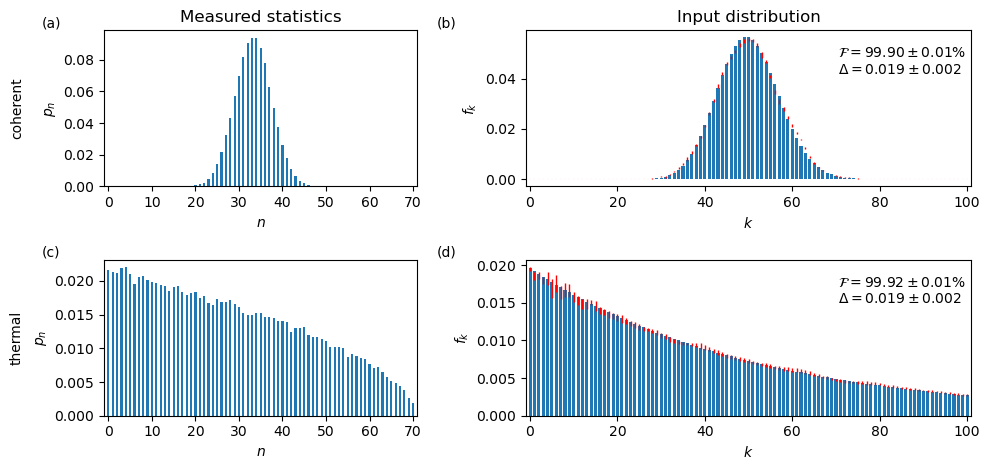

In [56]:
path = './Data/detector_70'
P_file = ['P_coherent_reconstr.npy', 'P_thermal_reconstr.npy']
F_file = ['F_coherent.npy', 'F_thermal.npy']
state = ['coherent', 'thermal']

p = []
f = []
for i in range(len(P_file)):
    P = np.load(os.path.join(path, P_file[i]))
    F = np.load(os.path.join(path, F_file[i]))
    p.append(P[12])
    f.append(F[12])

fig, axs = plt.subplots(2, 2, tight_layout=True, gridspec_kw=dict(width_ratios=[71, 101]), figsize=(10, 4.8))
axs[0, 0].set_title('Measured statistics')
axs[0, 1].set_title('Input distribution')

n = 101
text = [['(a)', '(b)'], ['(c)', '(d)']]
for i in range(2):
    # measured state
    axs[i,0].bar(range(p[i].shape[1]), p[i][1], width=.5)
    axs[i,0].set_xlim(-1, p[i].shape[1])
    axs[i,0].set_xlabel('$n$')
    axs[i,0].set_ylabel('$p_n$')
    axs[i,0].xaxis.set_major_locator(ticker.MultipleLocator(10))
    axs[i,0].text(-.2, 1, text[i][0], va='bottom', transform=axs[i,0].transAxes)
    axs[i,0].text(-.3, .5, state[i], rotation='vertical', va='center', transform=axs[i,0].transAxes)

    # input state
    input_ = utils.rho(50, f[i].shape[1]-1, state[i])
    fid = list(map(partial(utils.fidelity, input_), f[i]))
    fid_mean = np.mean(fid)
    fid_std = np.std(fid)
    TVD = list(map(partial(utils.TVD, input_), f[i]))
    TVD_mean = np.mean(TVD)
    TVD_std = np.std(TVD)
    axs[i,1].bar(range(n), input_[:n], width=.7)
    axs[i,1].errorbar(range(n), np.mean(f[i], axis=0)[:n], yerr=np.std(f[i], axis=0)[:n], elinewidth=1, capsize=1, capthick=0.01, ls='', c='r')
    axs[i,1].text(.7, .8, '$\mathcal{F}=$'+f'${fid_mean*100:.2f}\pm{fid_std*100:.2f}\%$'+'\n'+f'$\Delta={TVD_mean:.3f}\pm{TVD_std:.3f}$', va='center', transform=axs[i,1].transAxes)
    axs[i,1].set_xlim(-1, n)
    axs[i,1].set_xlabel('$k$')
    axs[i,1].set_ylabel('$f_k$')
    axs[i,1].xaxis.set_major_locator(ticker.MultipleLocator(20))
    axs[i,1].text(-.2, 1, text[i][1], va='bottom', transform=axs[i,1].transAxes)

fig.savefig('./Figures/ReconstructedStates.pdf')

#### 2.4.2 Plot the fidelity ~ $\langle n\rangle$ curve and $g^{2}(0)$ ~ $\langle n\rangle$ curve.

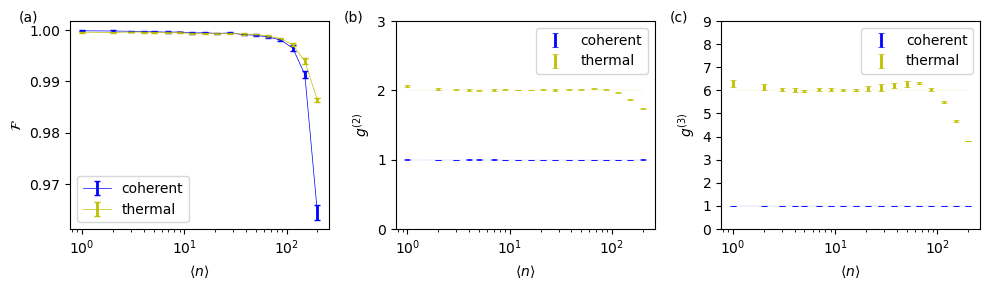

In [57]:
path = './Data/detector_70'
F_file = ['F_coherent.npy', 'F_thermal.npy']
state = ['coherent', 'thermal']
color = ['b', 'y']
nbar = np.array([1, 2, 3, 4, 5, 7, 9, 12, 16, 21, 28, 38, 50, 66, 87, 115, 151, 200])

fig, axs = plt.subplots(1, 3, tight_layout=True, figsize=(10, 3))
for i in range(2): # do not plot squeezed vacuum state and fock state
    F = np.load(os.path.join(path, F_file[i]))
    fid, fid_mean, fid_std = [], [], []
    g2, g2_mean, g2_std = [], [], []
    g3, g3_mean, g3_std = [], [], []
    for j in range(F.shape[0]):
        fid.append(list(map(partial(utils.fidelity, utils.rho(nbar[j], F.shape[2]-1, state[i])), F[j])))
        g2.append(list(map(partial(utils.gn, 2), F[j])))
        g3.append(list(map(partial(utils.gn, 3), F[j])))
    fid_mean, fid_std = np.mean(fid, axis=1), np.std(fid, axis=1)
    g2_mean, g2_std = np.mean(g2, axis=1), np.std(g2, axis=1)
    g3_mean, g3_std = np.mean(g3, axis=1), np.std(g3, axis=1)
    
    axs[0].errorbar(nbar, fid_mean, fid_std, ecolor=color[i], elinewidth=2, capsize=2, capthick=1, label=state[i], color=color[i], lw=.5)
    axs[1].errorbar(nbar, g2_mean, g2_std, ecolor=color[i], elinewidth=2, capsize=2, capthick=.5, lw=0, label=state[i])
    axs[2].errorbar(nbar, g3_mean, g3_std, ecolor=color[i], elinewidth=2, capsize=2, capthick=.5, lw=0, label=state[i])
    
    axs[0].set_xscale('log')
    axs[1].set_xscale('log')
    axs[2].set_xscale('log')
    
axs[0].set_xlabel(r'$\langle n\rangle$')
axs[0].set_ylabel('$\mathcal{F}$')
axs[0].text(-.2, 1, '(a)', transform=axs[0].transAxes)
axs[0].legend()

axs[1].hlines(1, min(nbar), max(nbar), colors=color[0], linestyle='dashed', lw=.1)
axs[1].hlines(2, min(nbar), max(nbar), colors=color[1], linestyle='dashed', lw=.1)
axs[2].hlines(1, min(nbar), max(nbar), colors=color[0], linestyle='dashed', lw=.1)
axs[2].hlines(6, min(nbar), max(nbar), colors=color[1], linestyle='dashed', lw=.1) 
# axs[1].plot(nbar, 3+1/nbar, color[2], lw=1, label=state[2]) # squuezed vacuum
# axs[1].plot(nbar, 1-1/nbar, color[3], lw=1, label=state[3]) # fock
axs[1].yaxis.set_major_locator(ticker.MultipleLocator(1))
axs[1].set_ylim(0, 3)
axs[1].set_ylabel('$g^{(2)}$')
axs[1].set_xlabel(r'$\langle n\rangle$')
axs[1].text(-.2, 1, '(b)', transform=axs[1].transAxes)
axs[1].legend()

axs[2].yaxis.set_major_locator(ticker.MultipleLocator(1))
axs[2].set_ylim(0, 9)
axs[2].set_ylabel('$g^{(3)}$')
axs[2].set_xlabel(r'$\langle n\rangle$')
axs[2].text(-.2, 1, '(c)', transform=axs[2].transAxes)
axs[2].legend()

fig.savefig('./Figures/fidelity-and-gn.pdf')

## 3. Benchmark the performance 

popt1=array([4.50645734e-04, 2.80494302e+00])
popt2=array([1.66164767e-06, 3.43778315e+00])
popt1_improved=array([7.17104304e-04, 2.56001970e+00])
popt2_improved=array([8.47313703e-07, 3.57640144e+00])


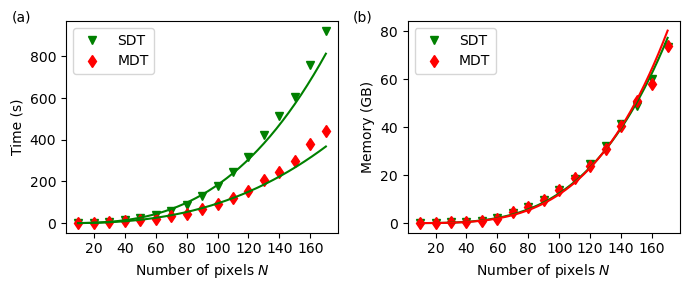

In [10]:
N = np.arange(10, 171, 10)
Time, Memory = np.empty(len(N)), np.empty(len(N))
for i, N_ in enumerate(N):
    Time[i], Memory[i] = np.load(f'./Data/detector_{N_}/TimeAndMemory.npy')
    Memory[i] = Memory[i]*2**20/10**9 # change the unit from MiB to GB

Time_improved, Memory_improved = np.empty(len(N)), np.empty(len(N))
for i, N_ in enumerate(N):
    Time_improved[i], Memory_improved[i] = np.load(f'./Data/detector_{N_}/TimeAndMemory_imporved.npy')
    Memory_improved[i] = Memory_improved[i]*2**20/10**9 # change the unit from MiB to GB
    
    
def scale_fun(N, a, b):
    '''The function used to fit the data.'''
    return a * N**b
def jac(N, a, b):
    '''Calculate the Jacobian matrix of scale_fun.'''
    return np.array((N**b, a*N**b*np.log(N))).T

# weighted least squares fit, refer to https://scipython.com/blog/least-squares-fitting-to-an-exponential-function/
popt1, pconv1 = curve_fit(scale_fun, N, Time, bounds=([0, 1], [np.inf, 10]), jac=jac, max_nfev=400, sigma=Time)
popt2, pconv2 = curve_fit(scale_fun, N, Memory, bounds=([0, 1], [np.inf, 5]), jac=jac, sigma=Memory)
print(f'{popt1=}', f'{popt2=}', sep='\n')

popt1_improved, pconv1_improved = curve_fit(scale_fun, N, Time_improved, bounds=([0, 1], [np.inf, 10]), jac=jac, max_nfev=400, sigma=Time_improved)
popt2_improved, pconv2_improved = curve_fit(scale_fun, N, Memory_improved, bounds=([0, 1], [np.inf, 5]), jac=jac, sigma=Memory_improved)
print(f'{popt1_improved=}', f'{popt2_improved=}', sep='\n')

fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(7, 3))

p1, = axs[0].plot(N, Time, 'vg', label='SDT')
p2, = axs[0].plot(N, Time_improved, 'dr', label='MDT')
axs[0].plot(np.arange(10, 171), scale_fun(np.arange(10, 171), *popt1), color=p1.get_color())
axs[0].plot(np.arange(10, 171), scale_fun(np.arange(10, 171), *popt1_improved), color=p1.get_color())

axs[1].plot(N, Memory, 'vg', label='SDT')
axs[1].plot(N, Memory_improved, 'dr', label='MDT')
axs[1].plot(np.arange(10, 171), scale_fun(np.arange(10, 171), *popt2), color=p1.get_color())
axs[1].plot(np.arange(10, 171), scale_fun(np.arange(10, 171), *popt2_improved), color=p2.get_color())

# axs[0].set_xlim(0, 200)
# axs[1].set_xlim(0, 200)
# axs[0].set_ylim(.1, 1e3)
# axs[1].set_ylim(10, 1e5)
axs[0].xaxis.set_major_locator(ticker.MultipleLocator(20))
axs[1].xaxis.set_major_locator(ticker.MultipleLocator(20))
axs[0].set_xlabel("Number of pixels $N$")
axs[1].set_xlabel("Number of pixels $N$")
axs[0].set_ylabel("Time (s)")
axs[1].set_ylabel("Memory (GB)")
axs[0].legend()
axs[1].legend()
axs[0].text(-.2, 1, '(a)', transform=axs[0].transAxes)
axs[1].text(-.2, 1, '(b)', transform=axs[1].transAxes)

# ax.yaxis.get_label().set_color(p1.get_color())
# twin.yaxis.get_label().set_color(p2.get_color())

# leg = ax.legend(handles=[p1, p2])
# leg.texts[0].set_color(p1.get_color())
# leg.texts[1].set_color(p2.get_color())

path = './Figures'
if not os.path.exists(path):
    os.mkdir(path)
fig.savefig('./Figures/Profile.pdf')

In [40]:
# Compare the solution of MDT and SDT
for N in range(10, 171, 10):
    Pi_improved = np.load(f'./Data/detector_{N}/Pi_improved.npy')
    Pi = np.load(f'./Data/detector_{N}/Pi.npy')
    rel = np.linalg.norm(Pi_improved-Pi, 'fro')/np.linalg.norm(Pi, 'fro') # relative error
    print(f'{N=},\t {rel:.2%}')

N=10,	 1.71%
N=20,	 1.21%
N=30,	 1.24%
N=40,	 1.01%
N=50,	 1.39%
N=60,	 1.50%
N=70,	 1.07%
N=80,	 1.83%
N=90,	 1.39%
N=100,	 1.12%
N=110,	 1.81%
N=120,	 2.63%
N=130,	 2.01%
N=140,	 1.90%
N=150,	 1.51%
N=160,	 1.80%
N=170,	 1.67%


In [12]:
# To what extent the degrees of freedom are reduced
def _get_U(M):
        U = 0
        for k in range(M):
            u = np.zeros(M+1)
            u[k] = 1
            u[k+1] = -1
            U += np.outer(u, u)
        return U

gamma = 1e-4
for N in range(10, 171, 10):
    P = np.load(f'./Data/detector_{N}/P_coherent.npy')
    D = P.shape[0]
    M = utils.get_M(D)
    F = utils.get_F(np.arange(1, D+1), M, 'coherent')
    Pi_ = np.linalg.inv(F.T@F + gamma*_get_U(M))@F.T@P
    print(f'{np.sum(Pi_<=0)/np.prod(Pi_.shape):.2%}')

0.3870967741935484
0.4210963455149502
0.41810935359322454
0.43916660740951435
0.4450206996951913
0.4472207248628595
0.4482064802608756
0.4517485258225999
0.46194546194546193
0.46281215152231947
0.46660549438327215
0.46705844045090167
0.46533270982486874
0.4679721732845462
0.47226576276499865
0.4718647304760758
0.4727026033435284
